In [10]:
%matplotlib inline

from weavingspace import Tileable
from weavingspace import TileUnit
from weavingspace import WeaveUnit
from weavingspace import tiling_utils

import geopandas as gpd
import shapely.geometry as geom
import topojson

<AxesSubplot:>

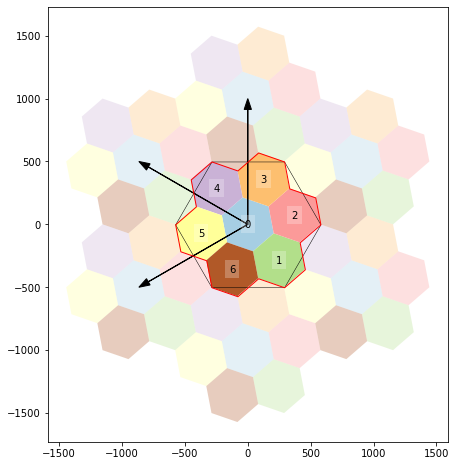

In [11]:
tile = TileUnit(
  # tiling_type = "hex-colouring", n = 7, dissection_offset = 1,
  # tiling_type = "hex-dissection", n = 12, dissection_offset = 1,
  tiling_type = "laves", n = 7, code = "3.3.3.3.6"
)
# tile = WeaveUnit(weave_type = "twill", n = 3, strands = "abc|def")
tile.plot(show_ids = "id", cmap = "Paired", r = 1, show_vectors = True)

In [12]:
patch = tile.get_local_patch(r = 1, include_0 = True)

## Make topology dictionary using `topojson`

In [13]:
patch_topology = topojson.Topology(patch, prequantize = True).to_dict()

## Recover vertices from the topology

<AxesSubplot:>

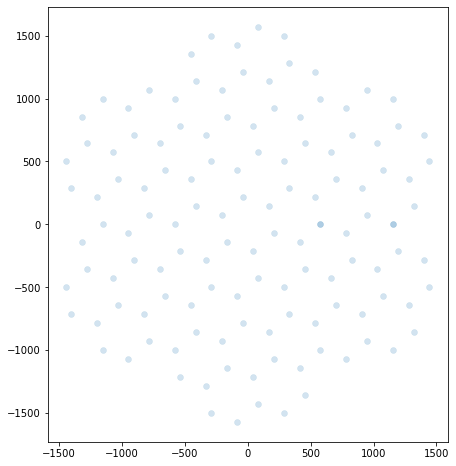

In [14]:
sx, sy = patch_topology["transform"]["scale"]
tx, ty = patch_topology["transform"]["translate"]

def get_index(x, iterable):
  if x in iterable:
    return iterable.index(x)
  else:
    return -1

vertices = []
edge_ids = []
points = []
for arc in patch_topology["arcs"]:
  pts = [arc[0]]
  for dxdy in arc[1:]:
    pts.append([pts[-1][0] + dxdy[0], pts[-1][1] + dxdy[1]])
  for p in pts:
    if p in vertices:
      continue
    else:
      vertices.append(p)
  edge_ids.append([get_index(p, vertices) for p in pts])
gs = gpd.GeoSeries([geom.Point(v) for v in vertices]) \
          .scale(sx, sy, origin = (0, 0)) \
          .translate(tx, ty)
points = gpd.GeoDataFrame({"id": range(len(gs))}, geometry = gs, crs = tile.crs)
points.plot(lw = 0.35, alpha = 0.2, figsize = (8, 8))

<AxesSubplot:>

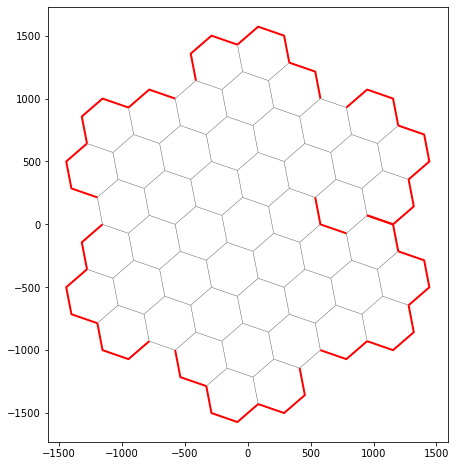

In [15]:
edges = []
for e in edge_ids:
  edges.append(geom.LineString([geom.Point(vertices[i]) for i in e]))
edges = gpd.GeoDataFrame({"length": [len(e) for e in edge_ids]}, crs = tile.crs,
                  geometry = gpd.GeoSeries(edges).scale(sx, sy, origin = (0, 0)).translate(tx, ty))
ax = edges.plot(ec = "#666666", figsize = (8, 8), lw = 0.5)
edges.loc[edges["length"] > 2].plot(ax = ax, ec = "r", lw = 2)

## Recover edges from the topology

<AxesSubplot:>

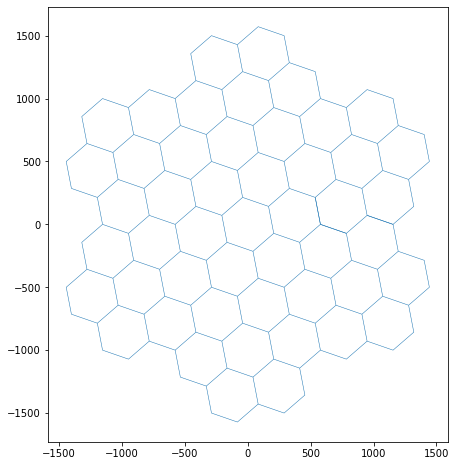

In [16]:
linestrings = []
for arc in patch_topology["arcs"]:
  pts = [arc[0]]
  for dxdy in arc[1:]:
    pts.append([pts[-1][0] + dxdy[0], pts[-1][1] + dxdy[1]])
  linestrings.append(geom.LineString(pts))
sx, sy = patch_topology["transform"]["scale"]
tx, ty = patch_topology["transform"]["translate"]
gs = gpd.GeoSeries(linestrings) \
          .scale(sx, sy, origin = (0, 0)) \
          .translate(tx, ty)
edges = gpd.GeoDataFrame({"id": range(len(gs))}, geometry = gs, crs = tile.crs)
edges.plot(lw = 0.5, figsize = (8, 8))

## Recover polygons from the topology

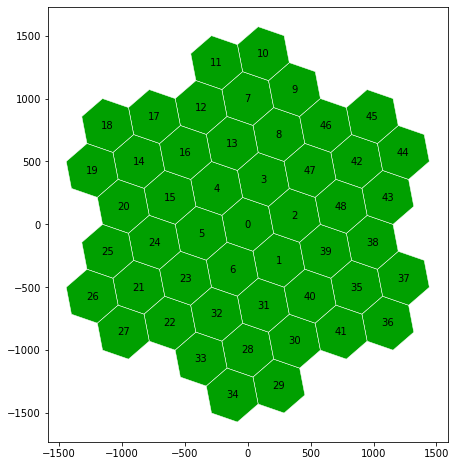

In [17]:
element_ids = []
polygons = []
for obj in patch_topology["objects"]["data"]["geometries"]:
  element_ids.append(obj["properties"]["element_id"])
  pts = []
  for arc in obj["arcs"][0]:
    if arc < 0:
      new_pts = list(reversed(edges.geometry[-arc - 1].coords))
    else:
      new_pts = edges.geometry[arc].coords
    if len(pts) == 0:
      pts.extend(new_pts)
    else:
      pts.extend(new_pts[1:])
  corners = [geom.Point(p) for p in pts]
  polygons.append(geom.Polygon(corners))
faces = gpd.GeoDataFrame(
  {"element_id": element_ids, "id": range(len(element_ids))},
  geometry = polygons, crs = tile.crs
)
ax = faces.plot(fc = "#00a000", ec = "w", lw = 0.5, figsize = (8, 8))
for polygon, name in zip(faces.geometry, faces.id):
    ax.annotate(xy = (polygon.centroid.x, polygon.centroid.y), text = name,
                horizontalalignment = "center", verticalalignment = "center")

## Get neighbours from topology
Code below determines face neighbours in the base tile unit, when tiled, i.e. some will not be neighbours in the base unit, but when tiled are neighbours.

In [18]:
sides = [obj["arcs"][0] 
         for obj in patch_topology["objects"]["data"]["geometries"]]
face_neighbours = [] # pairs of neighbouring tiles
for i, sides1 in enumerate(sides):
  for j, sides2 in enumerate(sides[i+1:]):
    for x, s1 in enumerate(sides1):
      if -s1 - 1 in sides2:
        face_neighbours.append((i, j + i + 1))
        continue

# ids are modulo the number of elements in the base tile unit
n = tile.elements.shape[0]
face_neighbours = [tuple(sorted([i % n, j % n])) for (i, j) in face_neighbours]
face_neighbours = sorted(list(set(face_neighbours)))
face_neighbours

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (3, 4),
 (3, 5),
 (3, 6),
 (4, 5),
 (4, 6),
 (5, 6)]